# Ornstein-uhlenbeck model fitting test environement

With the idea of exploring how the theory can be applied to real historic data a proof-of-concept is shown here where limited historic data is used:
1) To create a stationary portfolio
2) To fit Ornstein-uhlenbeck model to the data

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
from numpy.linalg import eig, norm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import time

## 0) Data loading

In [39]:
price_data  = pd.read_csv('yfinance_bel20_data_1h.csv').set_index('Datetime')
price_data = price_data.iloc[100:].dropna(axis=0)#.dropna(axis=0)
#price_data = price_data.fillna(0)
returns     = price_data.pct_change(1)
in_sample   = returns[:3*len(returns)//4]
out_sample  = returns[3*len(returns)//4+1:]

#pct_ret     = in_sample.loc[:,in_sample.max() < 1]
#log_ret = pd.read_csv('log_returns.csv').set_index('close_time')[1:len(pct_ret)//2]

In [ ]:
price_data  = pd.read_csv('futures_data_6h.csv').set_index('close_time')
price_data = price_data.iloc[2000:].dropna(axis=1)#.dropna(axis=0)
#price_data = price_data.fillna(0)
returns     = price_data.pct_change(1)
in_sample   = returns#[:3*len(returns)//4]
out_sample  = returns[3*len(returns)//4+1:]

pct_ret     = in_sample.loc[:,in_sample.max() < 1]
#log_ret = pd.read_csv('log_returns.csv').set_index('close_time')[1:len(pct_ret)//2]

FileNotFoundError: [Errno 2] No such file or directory: 'futures_data_6h.csv'

## 1) PCA factor model

In [3]:
def estimate_coefficients_LR(data, LOOKBACK_PERIOD):
    '''
    Estimates Ornstein-Uhlenbeck coefficients (θ, µ, σ) of the given array
    using the Linear regression method'''
    #fitting the model
    X = data[:-1].reshape(-1,1)
    y = data[1:]
    model2 = LinearRegression().fit(X,y)
    a = model2.intercept_
    b = model2.coef_
    pred = model2.predict(X)
    score = model2.score(X,y)
    zeta = y - pred
    # OU parameters 
    #b = 1e-6 if b < 0 else b
    kappa = -np.log(b) * LOOKBACK_PERIOD
    m = a/(1-b)
    sigma = np.sqrt(np.var(data)*2*kappa)
    sigma_eq = sigma / np.sqrt(2*kappa)
    return kappa[0], m[0], sigma[0], sigma_eq[0], score

In [4]:
import scipy.optimize as so
def compute_log_likelihood(params, *args):
    '''
    Compute the average Log Likelihood, this function will by minimized by scipy.
    Find in (2.2) in linked paper

    returns: the average log likelihood from given parameters
    '''
    # functions passed into scipy's minimize() needs accept one parameter, a tuple of
    #   of values that we adjust to minimize the value we return.
    #   optionally, *args can be passed, which are values we don't change, but still want
    #   to use in our function (e.g. the measured heights in our sample or the value Pi)
    m_i, kappa, sigma = params
    X, dt = args
    n = len(X)

    sigma_tilde_squared = sigma ** 2 * (1 - np.exp(-2 * kappa * dt)) / (2 * kappa)
    summation_term = 0

    for i in range(1, len(X)):
        summation_term += (X[i] - X[i - 1] * np.exp(-kappa * dt) - m_i * (1 - np.exp(-kappa * dt))) ** 2

    summation_term = -summation_term / (2 * n * sigma_tilde_squared)

    log_likelihood = (-np.log(2 * np.pi) / 2) + (-np.log(np.sqrt(sigma_tilde_squared))) + summation_term

    return -log_likelihood

def estimate_coefficients_MLE(X, dt, tol=1e-14):
    '''
    Estimates Ornstein-Uhlenbeck coefficients (θ, µ, σ) of the given array
    using the Maximum Likelihood Estimation method

    input: X - array-like time series data to be fit as an OU process
           dt - time increment (1 / days(start date - end date))
           tol - tolerance for determination (smaller tolerance means higher precision)
    returns: θ, µ, σ, Average Log Likelihood
    '''

    bounds = ((None, None), (1e-5, None), (1e-5, None))  # m_i ∈ ℝ, kappa > 0, sigma > 0
                                                           # we need 1e-10 b/c scipy bounds are inclusive of 0, 
                                                           # and sigma = 0 causes division by 0 error
    m_init = np.mean(X)
    initial_guess = (m_init, 0, 1)  # initial guesses for m_i, kappa, sigma
    result = so.minimize(compute_log_likelihood, initial_guess, args=(X, dt), bounds=bounds, tol=tol)
    m, kappa, sigma = result.x 
    sigma_eq = sigma / np.sqrt(2*kappa)
    return kappa, m, sigma, sigma_eq, np.exp(result.fun)

In [8]:
def pca(returns:pd.DataFrame, res_cov_window_size:int = 100, loadings_window_size:int=50, amount_of_factors:int=3):
    '''
    Function that computes the percentage returns of a residual portfolio constructed using pca
    Also with the weights needed to construct all these portfolio's
    
    Residual_output  is a T x N matrix 
    Residual_portfolio is a T x N x N matrix where e.g res_portf[t,i, :] gives you the vector 
    with all the weights you need to construct the residual portfolio i at timestep t
    Recovering phi from residual portfolio can be done by slicing as follows res_portf[t,:,:]
    '''
    T, N                = returns.shape
    returns             = returns.to_numpy()
    residuals_output    = np.zeros((T, N), dtype=float)    
    residual_portfolio  = np.zeros((T, N, N), dtype=float)
    for t in range(res_cov_window_size+1,len(returns)):
        # only use the columns with no missing values
        idxsSelected = ~np.any(np.isnan(returns[(t - res_cov_window_size+1):t]), axis = 0).ravel()   
        if idxsSelected.sum() == 0:
            continue
        #calculate covariance
        res_cov_window = returns[(t - res_cov_window_size+1):t,idxsSelected]
        R_oos           = returns[((t+1) - res_cov_window_size+1):(t+1),idxsSelected] #TODO: adj for bias, original returns[(t - res_cov_window_size+1):(t+1),idxsSelected]
        res_mean = np.mean(res_cov_window,axis=0,keepdims=True)
        res_vol = np.sqrt(np.mean((res_cov_window-res_mean)**2,axis=0,keepdims=True))
        res_normalized = (res_cov_window - res_mean) / res_vol
        Corr = np.dot(res_normalized.T, res_normalized)
        eigenValues, eigenVectors = np.linalg.eigh(Corr)

        #calculate loadings
        w           = eigenVectors[:,-amount_of_factors:].real                      # w
        R           = res_cov_window[-loadings_window_size:,:]
        wtR         = res_cov_window[-loadings_window_size:,:] @ w                  # R * w 
        regr        = LinearRegression(fit_intercept=False, n_jobs=-1).fit(wtR,R)
        beta        = regr.coef_                                                    #beta
        phi         = (np.eye(beta.shape[0]) - beta @ w.T)
        #TODO: is ther somethign wrong with the returns they use here??
        residuals   = phi @ R_oos[-1,:].T
        residuals_output[t:(t+1),idxsSelected]                = residuals
        i = 0
        for idx, val in enumerate(idxsSelected):
            if val:  
                residual_portfolio[t:(t+1),idx,idxsSelected] = phi[i,:].reshape([1,-1])
                i += 1  
    return residuals_output, residual_portfolio

In [296]:
def pca_limited(returns:pd.DataFrame, rebalance_speed=10, res_cov_window_size:int = 250, loadings_window_size:int=45, amount_of_factors:int=5):
    '''
    Function that computes the percentage returns of a residual portfolio constructed using pca
    Also with the weights needed to construct all these portfolio's
    
    Residual_output  is a T x N matrix 
    Residual_portfolio is a T x N x N matrix where e.g res_portf[t,i, :] gives you the vector 
    with all the weights you need to construct the residual portfolio i at timestep t
    Recovering phi from residual portfolio can be done by slicing as follows res_portf[t,:,:]
    '''
    T, N                = returns.shape
    returns             = returns.to_numpy()
    residuals_output    = np.zeros((T, N), dtype=float)    
    residual_portfolio  = np.zeros((T, N, N), dtype=float)
    begin = min(rebalance_speed, res_cov_window_size)
    epochs = int(len(returns) // rebalance_speed)

    for epoch in range(1,epochs-1):
        # only use the columns with no missing values
        if epoch*rebalance_speed- res_cov_window_size < 0:
            continue
        idxsSelected = ~np.any(np.isnan(returns[epoch*rebalance_speed- res_cov_window_size:epoch*rebalance_speed]), axis = 0).ravel()   
        if idxsSelected.sum() == 0:
            continue
        #calculate covariance
        res_cov_window = returns[epoch*rebalance_speed- res_cov_window_size:epoch*rebalance_speed,idxsSelected]
        R_oos           = returns[epoch*rebalance_speed:(epoch+1)*rebalance_speed,idxsSelected] #TODO: adj for bias, original returns[(t - res_cov_window_size+1):(t+1),idxsSelected]
        res_mean = np.mean(res_cov_window,axis=0,keepdims=True)
        res_vol = np.sqrt(np.mean((res_cov_window-res_mean)**2,axis=0,keepdims=True))
        res_normalized = (res_cov_window - res_mean) / res_vol
        Corr = np.dot(res_normalized.T, res_normalized)
        eigenValues, eigenVectors = np.linalg.eigh(Corr)

        #calculate loadings
        w           = eigenVectors[:,-amount_of_factors:].real                      # w
        R           = res_cov_window[-loadings_window_size:,:]
        wtR         = res_cov_window[-loadings_window_size:,:] @ w                  # R * w 
        regr        = LinearRegression(fit_intercept=False, n_jobs=-1).fit(wtR,R)
        beta        = regr.coef_                                                    #beta
        phi         = (np.eye(beta.shape[0]) - beta @ w.T)
        #TODO: is ther somethign wrong with the returns they use here??
        residuals   = phi @ R_oos.T
        residuals_output[epoch*rebalance_speed:(epoch+1)*rebalance_speed,idxsSelected]                = residuals.T
        i = 0
        for idx, val in enumerate(idxsSelected):
            if val:  
                residual_portfolio[epoch*rebalance_speed:(epoch+1)*rebalance_speed,idx,idxsSelected] = phi[i,:].reshape([1,-1])
                i += 1  
    return residuals_output, residual_portfolio

In [297]:
test                      = pct_ret
PCA, pca_portfolio        = pca_limited(test) 
residuals                 = pd.DataFrame(PCA, index=test.index, columns=test.columns)

In [298]:
(np.abs((pca_portfolio[:-1,:,:] - pca_portfolio[1:,:,:]))).mean()

0.004405102476848432

Text(0.5, 1.0, 'Residuals created for selected BEL20 stocks, rebalanced every timestep')

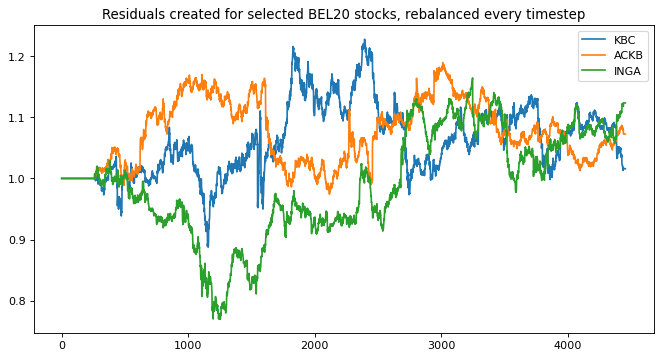

In [299]:
plt.figure(figsize=(10,5),dpi=80)
plt.plot((residuals[['KBC.BR','ACKB.BR','INGA.AS']].values+1).cumprod(axis=0))
plt.legend(['KBC','ACKB','INGA'])
plt.title('Residuals created for selected BEL20 stocks, rebalanced every timestep')

Text(0.5, 1.0, 'Correlation matrix of the residuals')

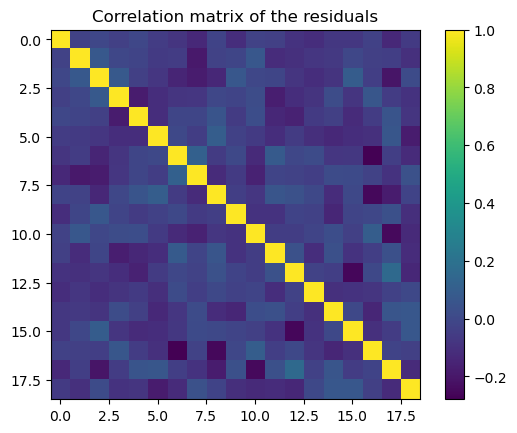

In [300]:
ax1 = plt.imshow(residuals.corr(),)
plt.colorbar(ax1)
plt.title('Correlation matrix of the residuals')

## 2) PCA factor model rebalancing times

In [11]:
rebalance_times = list(range(1,60))
result_cost = list()
result_kappa = list()
result_r2 = list()

for time in rebalance_times:
    print(time)
    PCA, pca_portfolio        = pca_limited(pct_ret,rebalance_speed=time) 
    avg_change= (np.abs((pca_portfolio[:-1,:,:] - pca_portfolio[1:,:,:]))).mean()
    T, N = PCA.shape
    kappas = list()
    R2s    = list()
    for idx in range(N):
        kappa, _,_,_,R2 = estimate_coefficients_LR((PCA[:,idx]+1).cumprod(),T)
        kappas.append(kappa)
        R2s.append(R2)
    result_kappa.append(sum(kappas)/N)
    result_r2.append(sum(R2s)/N)
    result_cost.append(avg_change)    

1


KeyboardInterrupt: 

In [18]:
LR.intercept_, LR.coef_
LR.estimate(np.array(rebalance_times).reshape(-1,1))

AttributeError: 'LinearRegression' object has no attribute 'estimate'

Text(0, 0.5, '$avg. \\theta$ from OU-fit')

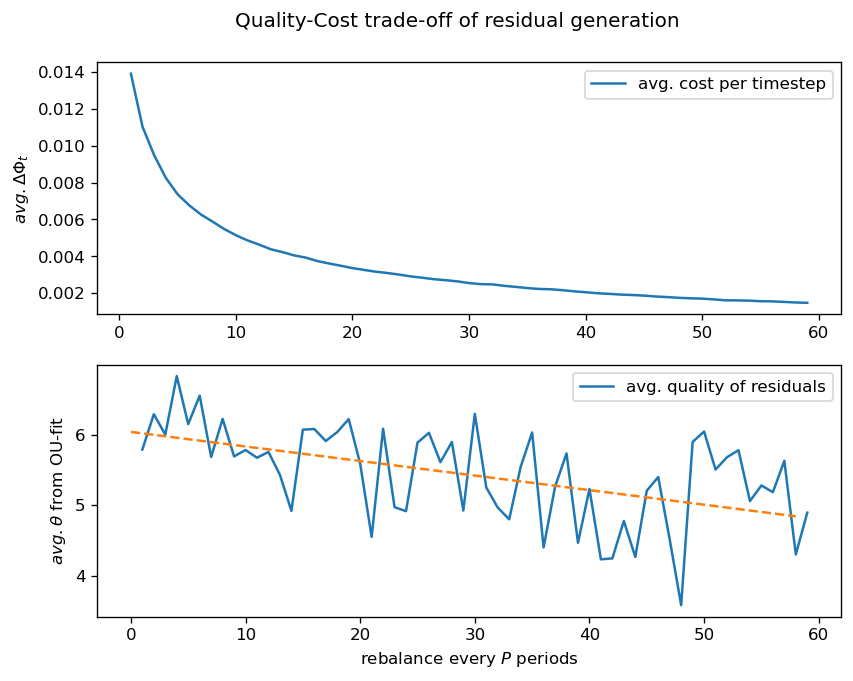

In [26]:
fig, ax = plt.subplots(2,1,figsize=(8,6),dpi=120)
#plt.tight_layout()
plt.suptitle('Quality-Cost trade-off of residual generation',y=0.95)
# plot a sample path of the wealth
ax[0].plot(rebalance_times, result_cost)
ax[0].legend([r'avg. cost per timestep'])
ax[0].set_ylabel(r'$avg. \Delta\Phi_t$')
ax[1].set_xlabel(r'rebalance every $P$ periods')
#ax[0].set_xlabel('Time')
ax[1].plot(rebalance_times,result_kappa)
LR = LinearRegression(fit_intercept=True, n_jobs=-1).fit(np.array(rebalance_times).reshape(-1,1),result_kappa)
ax[1].plot(LR.predict(np.array(rebalance_times).reshape(-1,1)),'--')
ax[1].legend([r'avg. quality of residuals'])
ax[1].set_ylabel(r'$avg. \theta$ from OU-fit')
#ax[2].plot(rebalance_times,result_r2)
#ax[2].legend([r'$R^2$ of OU fit'])


In [14]:
def preprocess_ou(data:np.array, lookback:int=40):
    #print("Start OU preprocess")
    signal_length = 4
    T,N = data.shape
    cumsums = np.cumsum(data, axis=0)
    windows = np.zeros((T-lookback, N, signal_length), dtype=np.float32)
    idxs_selected = np.zeros((T-lookback,N), dtype=bool)
    for t in range(lookback,T):
        # chooses stocks which have no missing returns in the t-th lookback window
        idxs_selected[t-lookback,:] = ~np.any(data[(t-lookback):t,:] == 0, axis=0).ravel() 
        idxs = idxs_selected[t-lookback,:]
        if t == lookback:
            x = cumsums[t-lookback:t,idxs].T
        else:
            # Probably unnecessary given the conv normalization, but is just to have the same setting as in the OU case
            x = cumsums[t-lookback:t,idxs].T - cumsums[t-lookback-1,idxs].reshape(int(sum(idxs)),1)
        Nx,Tx = x.shape
        #TODO: Is this where we make sure we dont have any look ahead bias?
        Ys = x[:,1:] #(N,T-1) 
        Xs = x[:,:-1]
        meansX = np.mean(Xs,axis=1) #(N)
        meansY = np.mean(Ys,axis=1)
        VarsX = np.var(Xs,axis=1) #N
        VarsY = np.var(Ys,axis=1)
        Covs = np.mean((Xs-meansX.reshape((Nx,1)))*(Ys-meansY.reshape((Nx,1))),axis=1) #N
        R2 = Covs**2/(VarsX*VarsY) #N
        bs = Covs/VarsX #N
        cs = (meansY - bs*meansX)
        mus = (cs/(1-bs+0.000001))
        mask = ((bs > 0) * (bs < 1))
        #kappas = -np.log(bs)/Deltat #if bs betwen 0 and 1
        residuals = Ys - bs.reshape((Nx,1))*Xs - cs.reshape((Nx,1)) #(N,T-1)
        sigmas = np.sqrt(np.var(residuals, axis=1)/np.abs(1-bs**2+0.000001)) #N
        signal = np.zeros((Nx))
        #signal =  (mus - Ys[:,-1])/sigmas * mask 
        signal[mask] = (mus[mask] - Ys[:,-1][mask])/sigmas[mask]
        windows[t-lookback,idxs,0] = Ys[:,-1]
        windows[t-lookback,idxs,1] = mus
        windows[t-lookback,idxs,2] = sigmas
        windows[t-lookback,idxs,3] = R2
#         if (t-lookback) % 100 == 0:
#             logging.info(f"idxs_selected before & mask: {np.sum(idxs_selected[t-lookback,:])}")
        idxs_selected[t-lookback,idxs] = idxs_selected[t-lookback,idxs] & mask
#         if (t-lookback) % 100 == 0:
#             logging.info(f"idxs_selected after & mask: {np.sum(idxs_selected[t-lookback,:])}")
    idxs_selected = torch.as_tensor(idxs_selected)
    #print("Finish OU preprocess")
    return windows, idxs_selected

In [15]:
plt.plot(np.flip(eigenValues / eigenValues.sum()))
plt.title('SCREE plot of eigenvalues')

NameError: name 'eigenValues' is not defined

## 3) RP-PCA factor model

In [38]:
is_returns = pct_ret

In [20]:
#finding factors using RP-PCA
gamma = 20
T,N = is_returns.shape
res_mean = np.mean(is_returns,axis=0,keepdims=True)
RPPCA_matrix = 1/T * is_returns.T @ is_returns + gamma * res_mean @ res_mean.T
eigenValues, eigenVectors = np.linalg.eigh(RPPCA_matrix)

#calculate loadings
w           = eigenVectors[:,-amount_of_factors:].real                      # w
R           = is_returns
wtR         = is_returns @ w                  # R * w 
regr        = LinearRegression(fit_intercept=False, n_jobs=-1).fit(wtR,R)
beta        = regr.coef_                                                    #beta
phi         = (np.eye(beta.shape[0]) - beta @ w.T)

is_residuals   = phi @ R.T
oos_residuals  = phi @ oos_returns.T

NameError: name 'is_returns' is not defined

## 4) Sparse PCA factor model

In [217]:
amount_of_factors = 3
sparsity = 0.4 # the amount of smallest entries that will be set to 0

In [218]:
is_returns = in_sample.dropna().values
oos_returns = out_sample.dropna().values

In [219]:
def set_sparsity(array, spar):
    rows, cols = array.shape
    n = int(np.floor(spar*rows))
    out_array = array.copy()
    for col in range(cols):
        out_array[np.argsort(np.abs(array[:,col].flatten()))[:n],col] = 0
        out_array[:,col] = out_array[:,col] / np.linalg.norm(out_array[:,col],2)
    return out_array

In [220]:
from sklearn import linear_model
#finding factors using sparse pca
T,N = is_returns.shape
res_mean = np.mean(is_returns,axis=0,keepdims=True)
PCA_matrix = 1/(T*N) * is_returns.T @ is_returns
eigenValues, eigenVectors = np.linalg.eigh(PCA_matrix)

#calculate loadings
w           = eigenVectors[:,-amount_of_factors:].real                      # w
#w           = eigenVectors[:,-amount_of_factors:].real                      # w
sparse_w    = set_sparsity(w, sparsity)
R           = is_returns
wtR         = is_returns @ sparse_w                  # R * w 
regr        = LinearRegression(fit_intercept=False,n_jobs=1).fit(wtR,R)
beta        = regr.coef_                                                    #beta
phi         = (np.eye(beta.shape[0]) - beta @ sparse_w.T)

is_residuals   = phi @ R.T
oos_residuals  = phi @ oos_returns.T

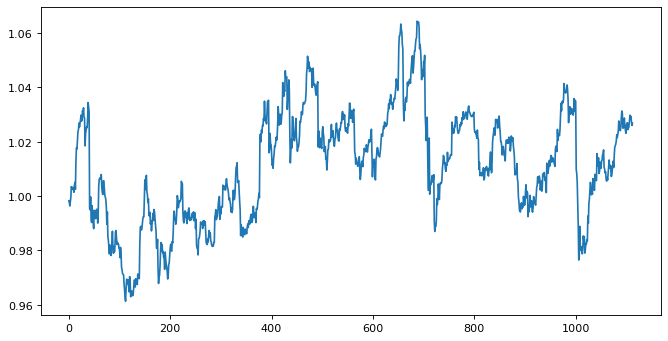

In [221]:
plt.figure(figsize=(10,5),dpi=80)
plt.plot((oos_residuals[15,:]+1).cumprod(axis=0))

In [287]:
def pca_sparse_limited(returns:pd.DataFrame, rebalance_speed=10, res_cov_window_size:int = 250, loadings_window_size:int=45, amount_of_factors:int=5):
    '''
    Function that computes the percentage returns of a residual portfolio constructed using pca
    Also with the weights needed to construct all these portfolio's
    
    Residual_output  is a T x N matrix 
    Residual_portfolio is a T x N x N matrix where e.g res_portf[t,i, :] gives you the vector 
    with all the weights you need to construct the residual portfolio i at timestep t
    Recovering phi from residual portfolio can be done by slicing as follows res_portf[t,:,:]
    '''
    T, N                = returns.shape
    returns             = returns.to_numpy()
    residuals_output    = np.zeros((T, N), dtype=float)    
    residual_portfolio  = np.zeros((T, N, N), dtype=float)
    begin = min(rebalance_speed, res_cov_window_size)
    epochs = int(len(returns) // rebalance_speed)

    for epoch in range(1,epochs-1):
        # only use the columns with no missing values
        if epoch*rebalance_speed- res_cov_window_size < 0:
            continue
        idxsSelected = ~np.any(np.isnan(returns[epoch*rebalance_speed- res_cov_window_size:epoch*rebalance_speed]), axis = 0).ravel()   
        if idxsSelected.sum() == 0:
            continue
        #calculate covariance
        res_cov_window = returns[epoch*rebalance_speed- res_cov_window_size:epoch*rebalance_speed,idxsSelected]
        R_oos           = returns[epoch*rebalance_speed:(epoch+1)*rebalance_speed,idxsSelected] #TODO: adj for bias, original returns[(t - res_cov_window_size+1):(t+1),idxsSelected]
        res_mean = np.mean(res_cov_window,axis=0,keepdims=True)
        res_vol = np.sqrt(np.mean((res_cov_window-res_mean)**2,axis=0,keepdims=True))
        res_normalized = (res_cov_window - res_mean) / res_vol
        Corr = np.dot(res_normalized.T, res_normalized)
        eigenValues, eigenVectors = np.linalg.eigh(Corr)

        #calculate loadings
        w           = eigenVectors[:,-amount_of_factors:].real                      # w
        sparse_w    = set_sparsity(w, sparsity)
        R           = res_cov_window[-loadings_window_size:,:]
        
        wtR         = res_cov_window[-loadings_window_size:,:] @ sparse_w                  # R * w 
        regr        = LinearRegression(fit_intercept=False, n_jobs=-1).fit(wtR,R)
        beta        = regr.coef_                                                    #beta
        phi         = (np.eye(beta.shape[0]) - beta @ sparse_w.T)
        #TODO: is ther somethign wrong with the returns they use here??
        residuals   = phi @ R_oos.T
        residuals_output[epoch*rebalance_speed:(epoch+1)*rebalance_speed,idxsSelected]                = residuals.T
        i = 0
        for idx, val in enumerate(idxsSelected):
            if val:  
                residual_portfolio[epoch*rebalance_speed:(epoch+1)*rebalance_speed,idx,idxsSelected] = phi[i,:].reshape([1,-1])
                i += 1  
    return residuals_output, residual_portfolio

In [288]:
test                      = pct_ret
PCA, pca_portfolio        = pca_sparse_limited(test) 
residuals                 = pd.DataFrame(PCA, index=test.index, columns=test.columns)

In [289]:
(np.abs((pca_portfolio[:-1,:,:] - pca_portfolio[1:,:,:]))).mean()

0.004856545003722146

In [291]:
(residuals.values+1).cumprod(axis=0)[-1,:]

array([1.38418372, 1.01085251, 1.24921301, 1.10239847, 1.35069971,
       0.64948539, 0.51386224, 0.97548906, 1.41586427, 0.99344852,
       1.57979834, 1.21865967, 1.10154875, 0.85157729, 0.81875768,
       1.05367305, 0.94881564, 0.80329228, 0.69175955])

Text(0.5, 1.0, 'Residuals created for selected BEL20 stocks, rebalanced every timestep')

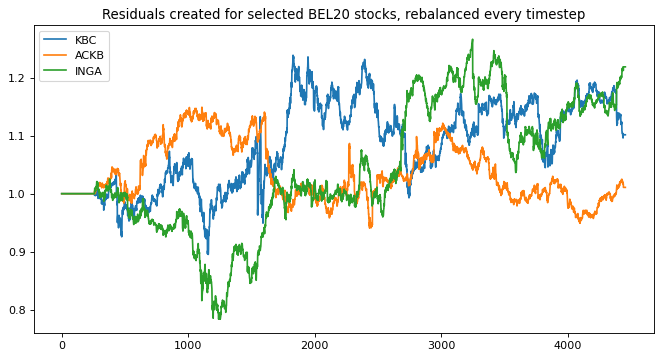

In [295]:
plt.figure(figsize=(10,5),dpi=80)
plt.plot((residuals[['KBC.BR','ACKB.BR','INGA.AS']].values+1).cumprod(axis=0))
plt.legend(['KBC','ACKB','INGA'])
plt.title('Residuals created for selected BEL20 stocks, rebalanced every timestep')

## 5) Instrumented PCA factor model

In [24]:
import numpy as np
from statsmodels.datasets import grunfeld
data = grunfeld.load_pandas().data
data.year = data.year.astype(np.int64)

# Establish unique IDs to conform with package
N = len(np.unique(data.firm))
ID = dict(zip(np.unique(data.firm).tolist(),np.arange(1,N+1)))
data.firm = data.firm.apply(lambda x: ID[x])

In [28]:
data

invest     value  capital
firm year                            
6    1935  317.600  3078.500    2.800
     1936  391.800  4661.700   52.600
     1937  410.600  5387.100  156.900
     1938  257.700  2792.200  209.200
     1939  330.800  4313.200  203.400
...            ...       ...      ...
1    1950    4.770    36.494   75.847
     1951    6.532    46.082   77.367
     1952    7.329    57.616   78.631
     1953    9.020    57.441   80.215
     1954    6.281    47.165   83.788

[220 rows x 3 columns]

In [25]:
# use multi-index for panel groups
data = data.set_index(['firm', 'year'])
y = data['invest']
X = data.drop('invest', axis=1)

In [26]:
X

value  capital
firm year                   
6    1935  3078.500    2.800
     1936  4661.700   52.600
     1937  5387.100  156.900
     1938  2792.200  209.200
     1939  4313.200  203.400
...             ...      ...
1    1950    36.494   75.847
     1951    46.082   77.367
     1952    57.616   78.631
     1953    57.441   80.215
     1954    47.165   83.788

[220 rows x 2 columns]

In [27]:
y

firm  year
6     1935    317.600
      1936    391.800
      1937    410.600
      1938    257.700
      1939    330.800
               ...   
1     1950      4.770
      1951      6.532
      1952      7.329
      1953      9.020
      1954      6.281
Name: invest, Length: 220, dtype: float64

In [29]:
# Call ipca
from ipca import InstrumentedPCA
regr = InstrumentedPCA(n_factors=1, intercept=False)
regr = regr.fit(X=X, y=y)
Gamma, Factors = regr.get_factors(label_ind=True)

The panel dimensions are:
n_samples: 11 , L: 2 , T: 20


Step 1 - Aggregate Update: 991039.6928694912
Step 2 - Aggregate Update: 0.031168457034450897
Step 3 - Aggregate Update: 0.013774627857866623
Step 4 - Aggregate Update: 0.00604563746326045
Step 5 - Aggregate Update: 0.002646397095045494
Step 6 - Aggregate Update: 0.0011571703804068856
Step 7 - Aggregate Update: 0.0005057548444794835
Step 8 - Aggregate Update: 0.0002210022866201422
Step 9 - Aggregate Update: 9.656419373729741e-05
Step 10 - Aggregate Update: 4.219093867913193e-05
Step 11 - Aggregate Update: 1.8433811881629625e-05
Step 12 - Aggregate Update: 8.053932979534828e-06
-- Convergence Reached --


In [30]:
Gamma

,0
value,0.991659
capital,0.128886


In [31]:
Factors

,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954
0,0.103197,0.088449,0.08385,0.084507,0.072252,0.099507,0.122884,0.142262,0.119753,0.117973,0.108756,0.135752,0.157935,0.166054,0.148492,0.158663,0.159601,0.175938,0.192169,0.211106


In [33]:
pct_ret

,ABI.BR,ACKB.BR,AD.AS,AGS.BR,BEKB.BR,BPOST.BR,COFB.BR,COLR.BR,ELI.BR,GBLB.BR,GLPG.AS,INGA.AS,KBC.BR,ONTEX.BR,PROX.BR,SOLB.BR,TNET.BR,UCB.BR,UMI.BR
Datetime,,,,,,,,,,,,,,,,,,,
2021-09-07 08:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-07 09:00:00+00:00,-0.002588,-0.000654,-0.000884,-0.005348,0.000000,0.000000,-0.001456,-0.001046,-0.000954,-0.001642,-0.000392,-0.001187,-0.002208,0.001613,-0.007724,0.000446,-0.000627,-0.003270,-0.003300
2021-09-07 10:00:00+00:00,-0.000798,-0.000655,0.000177,-0.000701,0.000505,-0.000610,-0.002187,-0.003141,-0.000955,-0.000822,0.003137,-0.000509,-0.001106,0.002684,0.002395,-0.001785,0.001881,0.001640,0.001840
2021-09-07 11:00:00+00:00,-0.000599,0.001311,0.000000,0.000234,0.005048,0.000610,-0.001461,-0.000840,0.001912,0.001235,0.003714,0.000340,0.002492,-0.002677,0.000597,0.001341,-0.006258,0.002457,0.000735
2021-09-07 12:00:00+00:00,-0.004197,0.000000,-0.000354,0.000234,0.000000,-0.001220,-0.002195,-0.000210,-0.001908,-0.000616,0.001947,0.001528,0.002209,0.004831,-0.001493,-0.003125,0.001259,-0.001838,-0.000734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-22 07:00:00+00:00,0.015963,0.007020,0.006540,0.004361,0.012541,0.016659,0.013514,0.003400,0.013958,0.004974,-0.021359,0.012189,0.003854,0.005348,0.011115,0.009188,0.000000,0.002209,0.007712
2023-08-22 08:00:00+00:00,-0.004982,0.000000,-0.002924,-0.002714,0.001376,0.003543,0.004444,0.003954,0.000983,-0.000550,-0.001984,-0.000915,-0.000320,0.003989,0.002137,-0.000958,0.000000,0.009060,-0.001701
2023-08-22 09:00:00+00:00,0.000963,0.000000,-0.000489,0.001088,-0.001832,-0.002648,0.002212,0.002813,0.010805,0.001926,0.004544,0.000458,0.000000,0.001324,0.001523,-0.001918,0.000000,0.001941,0.005111


In [34]:
y = pct_ret['ABI.BR']

In [36]:
y

Datetime
2021-09-07 08:00:00+00:00         NaN
2021-09-07 09:00:00+00:00   -0.002588
2021-09-07 10:00:00+00:00   -0.000798
2021-09-07 11:00:00+00:00   -0.000599
2021-09-07 12:00:00+00:00   -0.004197
                               ...   
2023-08-22 07:00:00+00:00    0.015963
2023-08-22 08:00:00+00:00   -0.004982
2023-08-22 09:00:00+00:00    0.000963
2023-08-22 10:00:00+00:00   -0.001731
2023-08-22 11:00:00+00:00   -0.000964
Name: ABI.BR, Length: 4455, dtype: float64

In [35]:
regr = InstrumentedPCA(n_factors=3, intercept=False)
regr = regr.fit(X=pct_ret, y=y)
Gamma, Factors = regr.get_factors(label_ind=True)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed